## 遺伝子名からバープロットを作成する

Rを使用してボックスプロットを作図する。  
使用するデータは2_deeptoolsで作成したSRR*.txtファイルである。    
このファイルには各遺伝子IDごと（バリアントも別に表示されている）にシグナルの分布が行列形式で計算されたものである。  
300行にデータが分割されているため、各列でデータを足し上げる（=SUM_score)。  
遺伝子名を入力し、遺伝子iDに変換して抽出し、バープロットを作成する。る。

### 1つの遺伝子名についてのバープロット

In [80]:
# ヘッダー行がない場合のデータの読み込み
data <- read.table("/home/inou_doi/demo/2_igv/SRR7475873.txt", header = FALSE, sep = "\t", fill = TRUE)

In [81]:
# 一行目を削除する
data <- data[-1, ]

In [82]:
# 列名を定義する
colnames(data) <- c("chr", "start", "stop", "name", "period", "plus", paste0("data_", 1:300))

In [83]:
# "nan"を0に置き換える
data[data == "nan"] <- 0

In [84]:
# SUM_scoreをデータフレームに追加する
sum_score <- rowSums(data[ , 7:ncol(data)])
data$SUM_score <- sum_score

In [85]:
# ファイルを保存する
write.table(data, "/home/inou_doi/demo/2_igv/SRR7475873_modified.txt", sep = "\t", row.names = FALSE, col.names = TRUE)

In [88]:
# 修正したファイルを読み込む
modified_data <- read.table("/home/inou_doi/demo/2_igv/SRR7475873_modified.txt", header = TRUE, sep = "\t")

In [89]:
# 指定された列のみを抽出する
selected_columns <- modified_data[, c("chr", "start", "end", "name", "period", "plus", "SUM_score")]

In [90]:
# 新しいファイルに保存する
write.table(selected_columns, "/home/inou_doi/demo/2_igv/SRR7475873_selected_columns.txt", sep = "\t", row.names = FALSE, col.names = TRUE)

SUM_scoreが書かれたファイルに関して、遺伝子名(CD82)で探して、バープロットを行う。

In [123]:
# 必要なパッケージをインストール
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("AnnotationDbi")
BiocManager::install("org.Hs.eg.db")  # ヒトの遺伝子データベース


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'AnnotationDbi'”
Old packages: 'abind', 'amap', 'ape', 'aplot', 'askpass', 'backports',
  'bdsmatrix', 'BiocFileCache', 'biomaRt', 'Biostrings', 'bit', 'bit64',
  'bitops', 'boot', 'broom', 'BSgenome', 'bslib', 'cachem', 'callr', 'caTools',
  'ChIPpeakAnno', 'circlize', 'cli', 'clock', 'clusterProfiler', 'coda',
  'codetools', 'colorspace', 'commonmark', 'cpp11', 'crayon', 'crul', 'curl',
  'data.table', 'DBI', 'dbplyr', 'deldir', 'DESeq2', 'digest', 'DOSE', 'DT',
  'e1071', 'evaluate', 'farver', 'fastmap', 'fontawesome', 'foreign', 'fs',
  'future', 'future.apply', 'GenomeInfoDb', 'GenomicAlignment

In [159]:
# ggplot2パッケージをインストール
install.packages("ggplot2")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [160]:
# パッケージを読み込み
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)

In [161]:
# パッケージの動作を確認する
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)

In [147]:
# 変換したい遺伝子名のベクトルを定義
gene_names <- c("CD82")

# 遺伝子名をRefSeq IDに変換
refseq_ids <- mapIds(org.Hs.eg.db, keys = gene_names, column = "REFSEQ", keytype = "SYMBOL", multiVals = "first")

# 結果を表示
print(refseq_ids)

'select()' returned 1:many mapping between keys and columns



          CD82 
"NM_001024844" 


この結果（refseq_id)をデータとして格納する。  
refseq_idを使って/home/inou_doi/demo/2_igv/SRR7475873_selected_columns.txtと/home/inou_doi/demo/2_igv/SRR7475870_selected_columns.txtのファイルのnameの列から、該当する行のSUM_scoreを抽出する。  
該当する数値は複数ある可能性がある。  
二つのファイルから抽出されたSUM_scoreについて、バープロットを行う。その際のグラフの名前は遺伝子名とする。例）KLF2、EGR2、IL2

In [148]:
# 結果をデータとして格納
refseq_ids <- as.character(refseq_ids)

In [149]:
#　格納されたデータを確認する
print(refseq_ids)

[1] "NM_001024844"


In [150]:
# ファイルパスを定義
file1 <- "/home/inou_doi/demo/2_igv/SRR7475870_selected_columns.txt"
file2 <- "/home/inou_doi/demo/2_igv/SRR7475873_selected_columns.txt"

In [154]:
# ファイルからSUM_scoreを抽出する関数を定義
extract_sum_score <- function(file_path, refseq_ids) {
  data <- read.table(file_path, header = TRUE, sep = "\t")
  scores <- sapply(refseq_ids, function(id) {
    matched_rows <- grep(id, data$name)
    if (length(matched_rows) > 0) {
      return(data[matched_rows, "SUM_score"])
    } else {
      return(NA)
    }
  })
  return(scores)
}

In [155]:
# 各ファイルからSUM_scoreを抽出
scores1 <- extract_sum_score(file1, refseq_ids)
scores2 <- extract_sum_score(file2, refseq_ids)

In [156]:
# 抽出されたSUM_scoreを表示
print(scores1)
print(scores2)

NM_001024844 
    1473.552 
NM_001024844 
    2130.018 


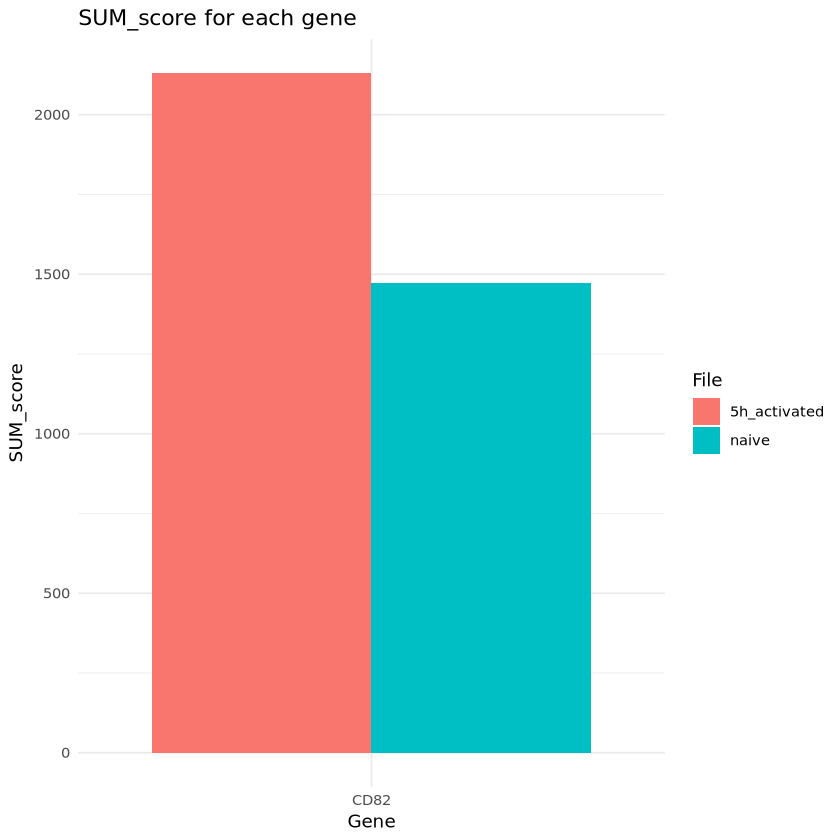

In [164]:
# データフレームを作成
if (length(scores1) > 0 & length(scores2) > 0) {
  df <- data.frame(
    Gene = rep(gene_names, each = 2),
    File = rep(c("naive", "5h_activated"), times = length(gene_names)),
    SUM_score = c(scores1, scores2)
  )

  # バープロットを作成
  ggplot(df, aes(x = Gene, y = SUM_score, fill = File)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "SUM_score for each gene", x = "Gene", y = "SUM_score") +
    theme_minimal()
} else {
  print("One or both of the score vectors are empty. Please check the input files and RefSeq IDs.")
}

### 複数の遺伝子名についてのバープロット

複数の遺伝子について比較検討したい際には、以下の方法で一度に解析することができる。

In [194]:
# 変換したい遺伝子名のベクトルを定義
gene_names <- c("KLF2", "EGR2", "IL2")

# 遺伝子名をRefSeq IDに変換
refseq_ids <- mapIds(org.Hs.eg.db, keys = gene_names, column = "REFSEQ", keytype = "SYMBOL", multiVals = "first")

# 結果を表示
print(refseq_ids)

# 結果をデータとして格納
refseq_ids <- as.character(refseq_ids)

print(refseq_ids)

# ファイルパスを定義
file1 <- "/home/inou_doi/demo/2_igv/SRR7475870_selected_columns.txt"
file2 <- "/home/inou_doi/demo/2_igv/SRR7475873_selected_columns.txt"

'select()' returned 1:many mapping between keys and columns



       KLF2        EGR2         IL2 
"NM_006075" "NM_000399" "NM_000586" 
[1] "NM_006075" "NM_000399" "NM_000586"


In [195]:
# ファイルからSUM_scoreを抽出する関数を定義（部分一致を使用）
extract_sum_score <- function(file_path, refseq_ids) {
  data <- read.table(file_path, header = TRUE, sep = "\t")
  scores <- sapply(refseq_ids, function(id) {
    matched_rows <- grep(id, data$name)
    if (length(matched_rows) > 0) {
      return(data[matched_rows, "SUM_score"])
    } else {
      return(NA)
    }
  })
  return(scores)
}

In [196]:
# 各ファイルからSUM_scoreを抽出
scores1 <- extract_sum_score(file1, refseq_ids)
scores2 <- extract_sum_score(file2, refseq_ids)

In [197]:
# 抽出されたSUM_scoreを表示
print(scores1)
print(scores2)

NM_006075 NM_000399 NM_000586 
       NA 1737.6673  240.1784 
NM_006075 NM_000399 NM_000586 
       NA  4091.240   772.579 


In [210]:
# 両方のスコアがNAである遺伝子を除外
valid_indices <- !(is.na(scores1) & is.na(scores2))
valid_gene_names <- gene_names[valid_indices]
valid_scores1 <- scores1[valid_indices]
valid_scores2 <- scores2[valid_indices]

In [211]:
# 抽出されたSUM_scoreを表示
print(scores1)
print(scores2)

NM_006075 NM_000399 NM_000586 
       NA 1737.6673  240.1784 
NM_006075 NM_000399 NM_000586 
       NA  4091.240   772.579 


In [212]:
# データフレームを作成
df <- data.frame(
  Gene = rep(valid_gene_names, each = 2),
  File = rep(c("naive", "5h_activated"), times = length(valid_gene_names)),
  SUM_score = c(as.numeric(valid_scores1), as.numeric(valid_scores2))
)

In [213]:
# データフレームの内容を表示
print(df)

  Gene         File SUM_score
1 EGR2        naive 1737.6673
2 EGR2 5h_activated  240.1784
3  IL2        naive 4091.2400
4  IL2 5h_activated  772.5790


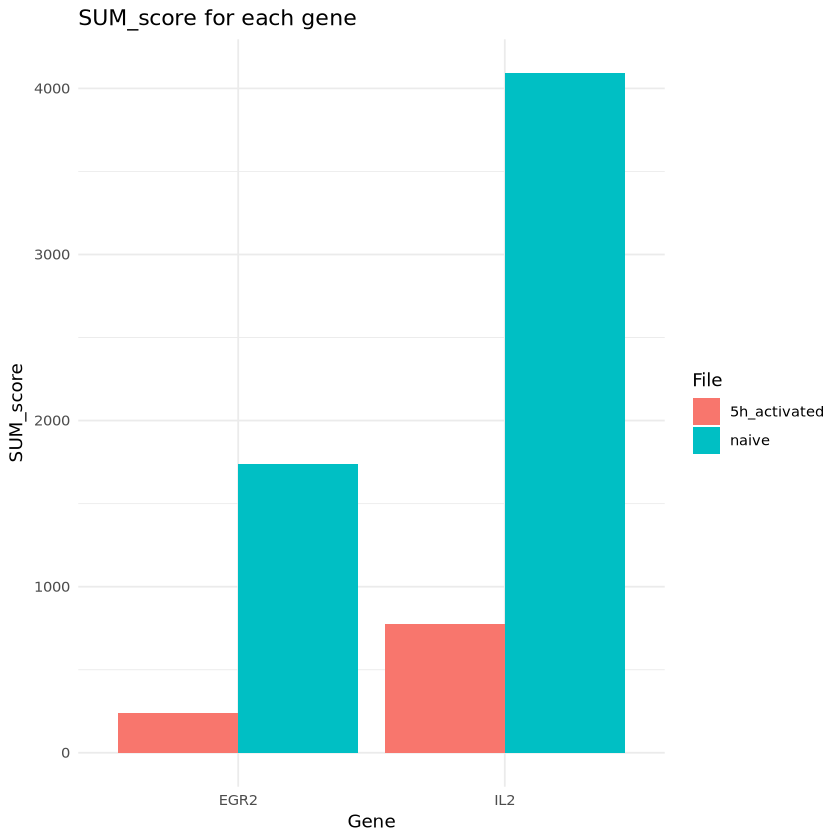

In [214]:
# バープロットを作成
ggplot(df, aes(x = Gene, y = SUM_score, fill = File)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "SUM_score for each gene", x = "Gene", y = "SUM_score") +
  theme_minimal()